### IMORTATIONS

In [8]:
from time import time
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

from kmerlib.running_window import *
from kmerlib.spectrum import *
from kmerlib.tools import *
from utils.term_colors import *

import json

# plot config
sns.set()
sns.set_context("talk")

In [9]:
%matplotlib notebook
#%matplotlib tk

In [10]:
# Plot colors
blue = "#089FB2"
green = "#C0C94F"
orange = "#FC933E"
red = "#F23957"

### CHARGEMENT DES DONNÉES

In [4]:
with open("./data/genes_dataset/5_genes_all_orgs_extended.json", "r") as f:
    all_genes = json.load(f)

In [6]:
print("Nombre de gènes:", len(all_genes))

Nombre de gènes: 525


### PRÉDICTIONS

In [11]:
# Predictions
def prediction(k):
    ref_data = list()
    for type_ in ("bacteria", "archaea"):
        path = Path("./data") / type_
        species = os.listdir(str(path))
        for name in species:
            file_name = "{}_k00{}.json".format(name, k)
            spec_path = path / name / file_name
            ref_data.append({
                "type": type_,
                "name": name,
                "spec": Spectrum(str(spec_path), True)
            })

    all_genes_comp = list()

    for gene in all_genes:
        type_ = all_genes[gene]['Clade']
        name = all_genes[gene]['Organism']
        all_genes_comp.append({
            "type": type_,
            "name": name,
            "spec": Spectrum(all_genes[gene]['Spectrums'][str(k)])
        })

    rslts = list()
    ranks = list()
    N = len(all_genes_comp)
    for i, gene in enumerate(all_genes_comp):
        spec = gene["spec"]
        target = gene["name"]
        d = list()
        for org in ref_data:
            ref_spec = org["spec"]
            d.append((dist(ref_spec, spec), org["name"]))
        key = lambda x: x[0]
        d.sort(key=key)
        if d[0][1] == target:
            rslts.append(1)
        else:
            rslts.append(0)
        names = [n for _, n in d]
        ranks.append(names.index(target) + 1)

    print("K={} | Accuracy: {}/{} ({:.2%}) | Mean rank: {:.2f} ±{:.2f}".format(k, sum(rslts), N, sum(rslts)/N,
                                                                               np.mean(ranks), np.std(ranks)))
    
    return sum(rslts)/N, np.mean(ranks)

In [12]:
# Predictions
def prediction_filt(k, win_len, step, win_filt, th, n_process=3):
    ref_data = list()
    for type_ in ("bacteria", "archaea"):
        dir_path = Path("./data") / type_
        species = os.listdir(str(dir_path))
        for i, name in enumerate(species):
            print(i+1, "/", len(species), name)
            
            path = dir_path / name
            files = os.listdir(str(path))
            fna_files = [f for f in files if ".fna" in f]
            if len(fna_files) < 1:
                print("PATH:", path)
                raise Exception("Several .fna files or no .fna file")
            path = path / fna_files[0]
            seq = load_seq_file(str(path))
            spec = kmer_spectrum(k, seq)
            
            running_dist = mproc_running_dist(
                k, seq, spec, win_len, step=step, n_process=n_process
            )
            running_dist = np.array(running_dist)
            running_dist = (running_dist -np.mean(running_dist))/np.std(running_dist)
            bp = np.array(range(0, len(running_dist)*step, step)) + int(win_len) // 2

            filt_win = 100
            filt_d = np.array(running_average(running_dist, filt_win))
            filt_bp = bp[filt_win//2:-filt_win//2]

            filt_seq = seq[:filt_bp[0]]
            for i in range(len(filt_bp)):
                if i == len(filt_bp) -1:
                    break
                if filt_d[i] > th and filt_d[i+1] > th:
                    filt_seq += seq[filt_bp[i]:filt_bp[i+1]]
            filt_seq += seq[filt_bp[-1]:]

            filt_spec = kmer_spectrum(k, filt_seq)
            
            ref_data.append({
                "type": type_,
                "name": name,
                "spec": filt_spec
            })

    all_genes_comp = list()

    for gene in all_genes:
        type_ = all_genes[gene]['Clade']
        name = all_genes[gene]['Organism']
        all_genes_comp.append({
            "type": type_,
            "name": name,
            "spec": Spectrum(all_genes[gene]['Spectrums'][str(k)])
        })

    rslts = list()
    ranks = list()
    N = len(all_genes_comp)
    for i, gene in enumerate(all_genes_comp):
        spec = gene["spec"]
        target = gene["name"]
        d = list()
        for org in ref_data:
            ref_spec = org["spec"]
            d.append((dist(ref_spec, spec), org["name"]))
        key = lambda x: x[0]
        d.sort(key=key)
        if d[0][1] == target:
            rslts.append(1)
        else:
            rslts.append(0)
        names = [n for _, n in d]
        ranks.append(names.index(target) + 1)

    print("K={} | Accuracy: {}/{} ({:.2%}) | Mean rank: {:.2f} ±{:.2f}".format(k, sum(rslts), N, sum(rslts)/N,
                                                                               np.mean(ranks), np.std(ranks)))
    
    return sum(rslts)/N, np.mean(ranks)

In [13]:
pers = list()
ranks = list()
Ks = (2, 3, 4, 5, 6)
for k in Ks:
    per, rank = prediction(k)
    pers.append(per)
    ranks.append(rank)


K=2 | Accuracy: 196/525 (37.33%) | Mean rank: 6.28 ±9.99
K=3 | Accuracy: 288/525 (54.86%) | Mean rank: 4.37 ±8.52
K=4 | Accuracy: 336/525 (64.00%) | Mean rank: 3.66 ±7.75
K=5 | Accuracy: 329/525 (62.67%) | Mean rank: 4.47 ±8.80
K=6 | Accuracy: 214/525 (40.76%) | Mean rank: 6.92 ±10.42


<IPython.core.display.Javascript object>


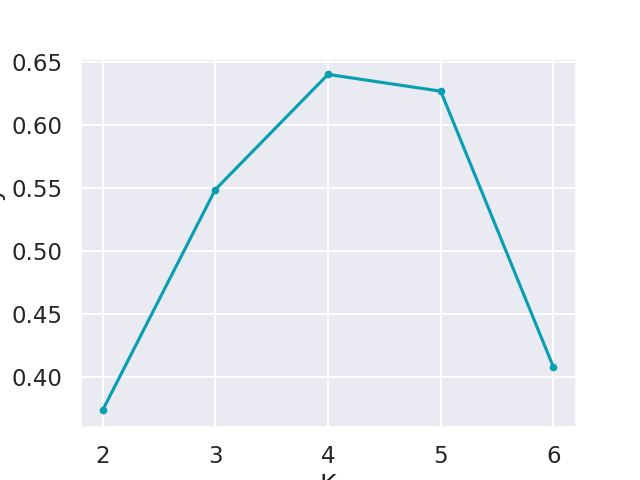

In [18]:
plt.figure()
plt.plot(Ks, pers, '.-', c=blue)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

<IPython.core.display.Javascript object>


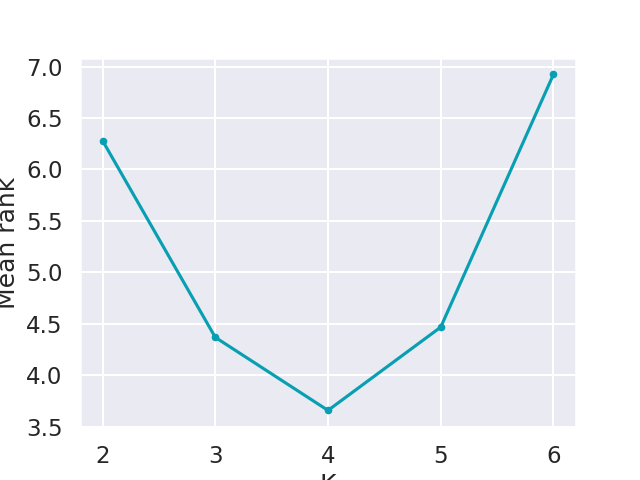

In [19]:
plt.figure()
plt.plot(Ks, ranks, '.-', c=blue)
plt.xlabel("K")
plt.ylabel("Mean rank")
plt.show()

Prédiction avec filtration des gènes candidats au transfert

In [19]:
prediction_filt(k=4, win_len=200, step=20, win_filt=50, th=1.2, n_process=3)

1 / 59 Chloroflexus_aurantiacus
2 / 59 Methylacidiphilum_infernorum
3 / 59 Acholeplasma_laidlawii
4 / 59 Acidobacteria_bacterium_JGI_0001001-H03
5 / 59 Acidobacterium_capsulatum
6 / 59 Actinomyces_bovis
7 / 59 Aeromonas_australiensis
8 / 59 Akkermansia_muciniphila
9 / 59 Alcaligenes_aquatilis
10 / 59 Alicyclobacillus_acidocaldarius
11 / 59 Aquifex_aeolicus
12 / 59 Bacillus_cereus
13 / 59 Bacillus_pseudofirmus
14 / 59 Bacteroides_fragilis
15 / 59 Bdellovibrio_bacteriovorus
16 / 59 Bordetella_pertussis
17 / 59 BRC1_bacterium_SCGC_AAA252-M09
18 / 59 Campylobacter_jejuni
19 / 59 Candidatus_Amoebophilus_asiaticus
20 / 59 Carboxydothermus_hydrogenoformans
21 / 59 Caulobacter_flavus
22 / 59 Chlamydia_trachomatis
23 / 59 Chlorobium_chlorochromatii
24 / 59 Clostridium_acetobutylicum
25 / 59 Corynebacterium_glutamicum
26 / 59 Coxiella_burnetii
27 / 59 Cupriavidus_taiwanensis
28 / 59 Cyanobacterium_aponinum
29 / 59 Cyanothece_sp._ATCC_51142
30 / 59 Deinococcus_radiodurans
31 / 59 Dictyoglomus_the

(0.18095238095238095, 17.626666666666665)